In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [12]:
import os
import pandas as pd

# set the directory path where the csv files are located
dir_path = './'

# get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# create an empty dictionary to store the dataframes
dfs = {}

# loop through each csv file and read it into a dataframe
for file in csv_files:
    # get the name of the file without the extension
    name = file.split('.')[0]
    # read the csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))
    # add the dataframe to the dictionary with the file name as the key
    dfs[name] = df

In [13]:
# Print the shape of the dataset
weather_data = dfs['weather_data']
sensor_readings = dfs['sensor_readings']
leak_locations_and_rate = dfs['leak_locations_and_rate']
curr_df = weather_data
print("Shape of the dataset: ", curr_df.shape)

Shape of the dataset:  (86401, 6)


In [14]:
time_classification_map = {}
for index, row in leak_locations_and_rate.iterrows():
    for i in range(row['tStart'], row['tEnd'] + 1):
        time_classification_map[i] = True

def get_leak_location_and_rate(time):
    return time_classification_map.get(time, False)

In [15]:
# create a numpy array with the same shape as detection_input
data = np.empty((24*86401, 2), dtype=object)

# loop through each row in sensor_readings dataframe
outer_index = 0
for index, row in sensor_readings.iterrows():
    # loop through each sensor in the row
    for col in sensor_readings.columns:
        if col not in ['Unnamed: 0', 'time']:
            value = row[col].astype(float)
            leak_probability = 0 if get_leak_location_and_rate(row['time']) else 1
            data[outer_index] = [value, leak_probability]
            outer_index += 1
            
    if index % 10000 == 0:
        print(index)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [16]:
# create the dataframe from the numpy array
detection_input = pd.DataFrame(data, columns=['value', 'leak_probability'])

# print the new dataframe
print(detection_input.head())

    value leak_probability
0  1030.0                1
1  1049.0                1
2  1166.0                1
3   964.0                1
4  1023.0                1


In [17]:
# remove rows with all values none
detection_input = detection_input.dropna()

In [18]:
# If necessary, convert 'leak_probability' to numerical or categorical format
detection_input['leak_probability'] = detection_input['leak_probability'].astype('int')

Accuracy:  0.8050844422897344
              precision    recall  f1-score   support

           0       0.86      0.73      0.79    181514
           1       0.77      0.88      0.82    181515

    accuracy                           0.81    363029
   macro avg       0.81      0.81      0.80    363029
weighted avg       0.81      0.81      0.80    363029



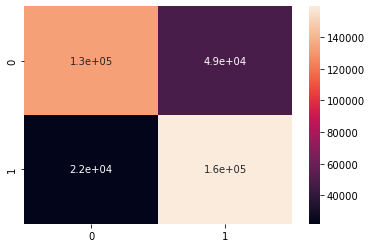

In [19]:
# train a random forest classifier on the data to see how well it can predict leak probability
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# define the number of folds
k = 1

# split x and y
X = detection_input.drop(columns=['leak_probability'])
y = detection_input['leak_probability']

# implement SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# create a KFold object
kf = StratifiedShuffleSplit(n_splits=k, random_state=None)

# remeber best model
best_model = None
best_model_accuracy = 0

# split the data into k folds
for train_index, test_index in kf.split(X, y):
    # get the training and testing data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train the decision tree classifier on the training data
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

    # scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # fit the model
    clf.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = clf.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    if accuracy > best_model_accuracy:
        best_model = clf
        best_model_accuracy = accuracy

    # print the classification report
    print(classification_report(y_test, y_pred))

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

In [20]:
# pickle the model
import pickle
filename = 'random_forest_detection_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [41]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import sklearn

def open_csv(sensor_file_path):
    sensor_df = pd.read_csv(sensor_file_path)
    return sensor_df

def process_sensor_data(sensor_df):
    # create a numpy array with the same shape as detection_input
    data = np.empty((24*sensor_df.shape[0], 3), dtype=object)

    # loop through each row in sensor_readings dataframe
    outer_index = 0
    for index, row in sensor_df.iterrows():
        # loop through each sensor in the row
        for col in sensor_df.columns:
            if col not in ['Unnamed: 0', 'time']:
                value = row[col].astype(float)
                leak_probability = 0
                data[outer_index] = [row['time'], value, leak_probability]
                outer_index += 1
                
        if index % 10000 == 0:
            print(index)

    # create the dataframe from the numpy array
    detection_input = pd.DataFrame(data, columns=['time', 'value', 'leak_probability'])

    # remove rows with all values none
    detection_input = detection_input.dropna()

    return detection_input

def load_model(model_name):
    # load the model from disk
    loaded_model = pickle.load(open(model_name, 'rb'))
    return loaded_model

def predict_leak(detection_input, loaded_model):
#drop time column
    # make predictions on the input data
    detection_input = detection_input.drop(columns=['leak_probability'])
    time = detection_input['time']
    detection_input = detection_input.drop(columns=['time'])

    scaler = StandardScaler()
    detection_input = scaler.fit_transform(detection_input)
    
    leak_probability = loaded_model.predict(detection_input)
    leaks = set()
    for time, leak in zip(time, leak_probability):
        if leak > 0:
            leaks.add(time)

    return leaks


In [45]:
print("made it into here")

# get input file names
sensor_data = 'sensor_readings.csv'
model_name = './random_forest_detection_model.sav'

# process inputs to fit models
sensor_df = open_csv(sensor_data)
detection_input = process_sensor_data(sensor_df)

# load model
loaded_model = load_model(model_name)

# make predictions
list_of_leaks = predict_leak(detection_input, loaded_model)

# print results
# print(f'List of leaks: {list_of_leaks}')

#calculate continuous intervals srtart times and end times of leaks
continuous_intervals = []
start_time = None
end_time = None
for time in list_of_leaks:
    if start_time == None:
        start_time = time
        end_time = time
    elif time == end_time + 1:
        end_time = time
    else:
        continuous_intervals.append((start_time, end_time))
        start_time = time
        end_time = time

# print results
print(f'Continuous intervals: {continuous_intervals}')

made it into here
0
10000
20000
30000
40000
50000
60000
70000
80000
Continuous intervals: [(1681776002.0, 1681776476.0), (1681776478.0, 1681780513.0), (1681780516.0, 1681780668.0), (1681780709.0, 1681780714.0), (1681780758.0, 1681780761.0), (1681780764.0, 1681790700.0), (1681790704.0, 1681820775.0), (1681820778.0, 1681820802.0), (1681820804.0, 1681820810.0), (1681820814.0, 1681820844.0), (1681820847.0, 1681820891.0), (1681820893.0, 1681828622.0), (1681828624.0, 1681829594.0), (1681829596.0, 1681831823.0), (1681831825.0, 1681841919.0), (1681841921.0, 1681841921.0), (1681841924.0, 1681841929.0), (1681841931.0, 1681841934.0), (1681841937.0, 1681841940.0), (1681841942.0, 1681841942.0), (1681841947.0, 1681841951.0), (1681841956.0, 1681841963.0), (1681841966.0, 1681841970.0), (1681841975.0, 1681841975.0), (1681841977.0, 1681841978.0), (1681841982.0, 1681841982.0), (1681841984.0, 1681841986.0), (1681841989.0, 1681841990.0), (1681841992.0, 1681841992.0), (1681841996.0, 1681842000.0), (16818420

In [34]:
detection_input.drop(columns=['leak_probability']).to_numpy()

array([[1030.0],
       [1049.0],
       [1166.0],
       ...,
       [1017.0],
       [846.0],
       [971.0]], dtype=object)

In [29]:
X_test

array([[-0.00624765],
       [-0.01092946],
       [-0.03046392],
       ...,
       [-0.02013165],
       [-0.03433852],
       [-0.01399686]])